In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from joblib import load, dump

import model_functions as mf
import eval_measures as ems

from IPython.display import display

MF reloaded 1
EMS reloaded


In [2]:
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
%%time
with pd.HDFStore('out/Training_2002_2005.middle.h5') as cstore:
    df_middle = cstore['middle_2nd_author']
    
print df_middle.shape
df_middle.columns

(34032575, 56)
CPU times: user 35 s, sys: 21.6 s, total: 56.6 s
Wall time: 56.6 s


In [4]:
df_middle.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

## Load author years data

In [5]:
%%time
df_authors = pd.read_csv("data/AuthorityFirstLastYears.txt", sep="\t").rename(
    columns={"au_id": "auid"})
df_authors.shape

CPU times: user 9.46 s, sys: 1.1 s, total: 10.6 s
Wall time: 13.6 s


In [6]:
df_authors.head()

,auid,first_year,last_year
0,9731334_2,1997,2009
1,2155715_1,1990,2009
2,7867892_1,1994,2009
3,14609221_2,2003,2009
4,8101337_1,1993,2007


In [7]:
df_authors.dtypes

auid          object
first_year     int64
last_year      int64
dtype: object

In [8]:
df_authors.describe().astype(int)

,first_year,last_year
count,9300182,9300182
mean,1989,1994
std,16,15
min,1865,0
25%,1980,1986
50%,1994,2000
75%,2003,2007
max,9999,2099


In [9]:
df_authors[df_authors.first_year == 9999].shape, df_authors[df_authors.first_year <= 1900].shape

((3, 3), (3858, 3))

## Load author expertise data

In [10]:
%%time
df_expertise = pd.read_csv("data/AuthorExpertise.txt", sep="\t")
df_expertise.columns, df_expertise.shape

CPU times: user 1min 2s, sys: 6.17 s, total: 1min 8s
Wall time: 1min 46s


In [11]:
df_expertise.columns, df_expertise.shape

(Index([u'PMID', u'auid', u'match_len', u'match_prop', u'overall_coverage_len',
        u'overall_coverage_prop'],
       dtype='object'), (58761322, 6))

In [12]:
df_expertise.dtypes

PMID                       int64
auid                      object
match_len                  int64
match_prop               float64
overall_coverage_len       int64
overall_coverage_prop    float64
dtype: object

## Middle 2nd author

In [14]:
%%time
print df_middle.shape
df_middle = df_middle.merge(df_authors, how="left", on="auid")
print df_middle.shape

(34032575, 56)
(34032575, 58)
CPU times: user 1min 21s, sys: 35.1 s, total: 1min 56s
Wall time: 1min 56s


In [15]:
df_middle["au_age"] = df_middle["source_year"] - df_middle["first_year"]

In [16]:
df_middle.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [17]:
%%time
print df_middle.shape
df_middle = df_middle.merge(df_expertise, how="left",
                          left_on=["source_id","auid"],
                          right_on=["PMID","auid"],)
print df_middle.shape

(34032575, 59)
(34033219, 64)
CPU times: user 1min 20s, sys: 24.3 s, total: 1min 44s
Wall time: 1min 44s


In [18]:
df_middle.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [19]:
%%time
df_middle = df_middle.drop("PMID", axis=1)
print df_middle.shape

(34033219, 63)
CPU times: user 39 s, sys: 36.6 s, total: 1min 15s
Wall time: 1min 15s


## Modelling considerations

In [20]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
GENDERS = ["-", "F", "M"]

def prepare_data(df):
    df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
    df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity
    df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown
    df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")
    df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
    df.ix[df.eth2.isin(
            ["UNKNOWN", "TOOSHORT", "ERROR"]),
          "eth2"] = "UNKNOWN" # Set unknown ethnicities
    df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
    df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")
    df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [21]:
prepare_data(df_middle)

## Overall data statistics

### Middle author

In [22]:
%%time
df_t_middle = df_middle.pivot_table(index="gender", columns="is_self_cite",
               values=["source_year", u'source_n_mesh', u'source_is_eng', 
                       u'source_is_journal', u'source_is_review',
                       u'source_is_case_rep', u'source_is_let_ed_com',
                       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
                       u'source_PV_novelty', u'source_ncites', u'source_n_authors',
                       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
                       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
                       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
                       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors',
                       u'year_span', u'journal_same',
                       u'mesh_sim', u'title_sim', u'lang_sim',
                       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
                       u'gender_sim', u'eth_sim', u'n_common_authors',
                       u'sink_last_ncites', u'sink_prev_ncites',
                       u'auth_last_npapers', u'auth_prev_papers',
                       u'au_age',
                       u'jj_sim', 
                       u'match_len', u'match_prop',
                       u'overall_coverage_len', u'overall_coverage_prop'
                      ],
                        aggfunc=[np.mean, np.std])
df_t_middle

CPU times: user 1min 36s, sys: 38.4 s, total: 2min 14s
Wall time: 2min 14s


In [23]:
df_t_middle.T.unstack(level=0).to_csv("Review_2_Figures/Middle_2nd_Author_gender_self_cites_means.txt", sep="\t")

In [24]:
with pd.option_context('display.max_rows', 100,
                       'display.max_columns', 20,
                       'display.precision', 3
                      ):
    display(df_t_middle.T.unstack(level=0))

gender                                     -                    F             \
                                        mean        std      mean        std   
                      is_self_cite                                             
source_year           0             2003.658      1.111  2003.633      1.111   
                      1             2003.653      1.116  2003.613      1.113   
source_n_mesh         0               13.705      5.754    13.726      5.469   
                      1               13.290      5.990    13.449      5.338   
source_is_eng         0                0.982      0.134     0.986      0.117   
                      1                0.995      0.069     0.991      0.092   
source_is_journal     0                0.991      0.093     0.991      0.095   
                      1                0.990      0.099     0.986      0.117   
source_is_review      0                0.107      0.310     0.145      0.352   
                      1                0.090      0.286     0.114      0.318   
source_is_case_rep    0                0.040      0.195     0.030      0.171   
                      1                0.014      0.116     0.014      0.118   
source_is_let_ed_com  0                0.009      0.093     0.009      0.093   
                      1                0.010      0.098     0.014      0.116   
source_T_novelty      0               19.739     12.385    20.337     12.364   
                      1               19.860     12.145    20.754     12.251   
source_V_novelty      0             3088.533  10406.100  3350.380  12802.351   
                      1             2979.999   5841.966  3252.005   9791.710   
source_PT_novelty     0                2.125      4.645     2.290      4.788   
                      1                2.047      4.400     2.303      4.723   
source_PV_novelty     0                7.863    214.260     9.350    261.953   
                      1                5.952     74.766     9.275    237.052   
source_ncites         0               42.346     42.680    48.131     52.823   
                      1               35.448     31.626    38.325     34.905   
source_n_authors      0                5.777      3.358     5.832      3.125   
                      1                5.931      5.902     5.860      3.212   
sink_year             0             1995.611      7.462  1995.706      7.341   
                      1             2000.520      3.314  2000.090      3.537   
sink_n_mesh           0               12.918      5.607    13.055      5.397   
                      1               13.434      6.038    13.685      5.349   
sink_n_mesh_ex        0               59.053     24.143    60.056     23.172   
                      1               61.910     26.742    63.600     23.521   
sink_is_eng           0                0.995      0.071     0.996      0.066   
                      1                0.995      0.067     0.994      0.075   
sink_is_journal       0                0.984      0.124     0.983      0.131   
                      1                0.990      0.097     0.989      0.105   
sink_is_review        0                0.144      0.351     0.147      0.355   
                      1                0.041      0.198     0.054      0.227   
sink_is_case_rep      0                0.032      0.176     0.028      0.166   
                      1                0.014      0.117     0.016      0.125   
sink_is_let_ed_com    0                0.016      0.125     0.018      0.131   
                      1                0.009      0.097     0.011      0.105   
sink_T_novelty        0               16.692     11.452    16.981     11.438   
                      1               17.990     11.669    18.694     11.654   
sink_V_novelty        0             2452.024   8329.038  2518.607   7910.966   
                      1             2432.913   5113.747  2591.274   7605.304   
sink_PT_novelty       0                1.790      4.387     1.823      4.402   


## Preliminary Statistics

In [25]:
df_middle.shape

(34033219, 64)

In [31]:
df_middle.is_self_cite.mean()

0.048513836389131565

In [26]:
df_middle.is_self_cite.value_counts()

0    32718316
1     1314903
Name: is_self_cite, dtype: int64

In [27]:
df_middle[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-    2.948911
F    3.166549
M    4.480517
Name: is_self_cite, dtype: float64

## Tables of gender self citation for age and prior papers

In [28]:
def filtered_data(df):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=60)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered

def aggregate_function(x, median_col="auth_prev_papers", span=1):
    median = x[median_col].median()
    x = x[(x[median_col] >= (median - span))
         & (x[median_col] <= (median + span))]
    t = x.groupby("gender")["is_self_cite"].agg([np.mean, len])
    t["median"] = median
    return t

### Middle author

In [29]:
%%time
df_t_middle = filtered_data(df_middle)
display(df_t_middle.pivot_table(index=pd.cut(df_t_middle.au_age,
                                    bins=[4,6,8,12,18,22,27,33]),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

(22745103, 64) (34033219, 64)
Filter dataset is 66.83% of the original data.


mean                     len                     
gender      -         F         M   -         F          M
au_age                                                    
(4, 6]    NaN  0.034708  0.039246 NaN  813473.0  1304296.0
(6, 8]    NaN  0.040002  0.044875 NaN  671410.0  1181985.0
(8, 12]   NaN  0.045129  0.051693 NaN  986743.0  1926475.0
(12, 18]  NaN  0.053600  0.059317 NaN  943313.0  2095319.0
(18, 22]  NaN  0.059764  0.067970 NaN  401596.0  1040606.0
(22, 27]  NaN  0.064690  0.073604 NaN  322507.0   956718.0
(27, 33]  NaN  0.069699  0.082472 NaN  201537.0   763544.0

CPU times: user 14.7 s, sys: 8.18 s, total: 22.8 s
Wall time: 22.8 s


In [30]:
df_t_middle[["gender", "is_self_cite"]].groupby("gender").is_self_cite.mean()* 100

gender
-         NaN
F    3.323997
M    4.671074
Name: is_self_cite, dtype: float64

In [31]:
df_t_middle.groupby(pd.cut(df_t_middle.au_age,
                                    bins=[4,6,8,12,18,22,27,33])).auth_prev_papers.describe().to_frame().unstack()

auth_prev_papers                                                \
                    count       mean        std  min   25%   50%    75%   
au_age                                                                    
(4, 6]          2117769.0   9.191009   8.422011  1.0   4.0   7.0   12.0   
(6, 8]          1853395.0  13.948754  13.106686  1.0   6.0  10.0   18.0   
(8, 12]         2913218.0  21.522653  20.649976  1.0   9.0  16.0   27.0   
(12, 18]        3038632.0  36.734218  35.716992  1.0  14.0  26.0   47.0   
(18, 22]        1442202.0  53.998857  52.017370  1.0  21.0  39.0   70.0   
(22, 27]        1279225.0  72.439056  76.183028  1.0  26.0  51.0   92.0   
(27, 33]         965081.0  94.756273  94.526219  1.0  34.0  67.0  122.0   

                  
             max  
au_age            
(4, 6]     109.0  
(6, 8]     182.0  
(8, 12]    462.0  
(12, 18]   640.0  
(18, 22]   672.0  
(22, 27]  1167.0  
(27, 33]  1098.0

In [32]:
df_t_middle.groupby(pd.cut(df_t_middle.au_age,
                                    bins=[0,1,2,3,4,6,8,12,18,22,27,33])).apply(aggregate_function).unstack()

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/pandas/indexes/category.py:118: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/pandas/indexes/category.py:118: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


mean                     len                 median            
gender      -         F         M   -       F       M      -     F     M
au_age                                                                  
(0, 1]    NaN  0.014303  0.015462   0  528194  601168    1.0   1.0   1.0
(1, 2]    NaN  0.019071  0.019978   0  451624  532030    2.0   2.0   2.0
(2, 3]    NaN  0.025184  0.026431   0  274812  334150    3.0   3.0   3.0
(3, 4]    NaN  0.034612  0.033865   0  153963  206616    5.0   5.0   5.0
(4, 6]    NaN  0.037907  0.038247   0  185479  266218    7.0   7.0   7.0
(6, 8]    NaN  0.042796  0.043230   0  108258  169512   10.0  10.0  10.0
(8, 12]   NaN  0.051910  0.049900   0   90695  166833   16.0  16.0  16.0
(12, 18]  NaN  0.062115  0.055623   0   47847  109757   26.0  26.0  26.0
(18, 22]  NaN  0.068441  0.070482   0   13413   32987   39.0  39.0  39.0
(22, 27]  NaN  0.078312  0.072431   0    6755   24575   51.0  51.0  51.0
(27, 33]  NaN  0.109053  0.076429   0    3347   13228   67.0  67.0  67.0

In [33]:
df_t_middle.groupby(pd.cut(df_t_middle.au_age,
                                    bins=range(25))).apply(aggregate_function).unstack()

mean                     len                 median            
gender      -         F         M   -       F       M      -     F     M
au_age                                                                  
(0, 1]    NaN  0.014303  0.015462   0  528194  601168    1.0   1.0   1.0
(1, 2]    NaN  0.019071  0.019978   0  451624  532030    2.0   2.0   2.0
(2, 3]    NaN  0.025184  0.026431   0  274812  334150    3.0   3.0   3.0
(3, 4]    NaN  0.034612  0.033865   0  153963  206616    5.0   5.0   5.0
(4, 5]    NaN  0.035643  0.036430   0  114553  159976    6.0   6.0   6.0
(5, 6]    NaN  0.040343  0.040364   0   76841  116812    8.0   8.0   8.0
(6, 7]    NaN  0.039900  0.041189   0   60050   96992    9.0   9.0   9.0
(7, 8]    NaN  0.044475  0.046197   0   46723   76953   11.0  11.0  11.0
(8, 9]    NaN  0.046160  0.045972   0   35377   58905   13.0  13.0  13.0
(9, 10]   NaN  0.052208  0.050369   0   24498   47291   15.0  15.0  15.0
(10, 11]  NaN  0.054866  0.052138   0   20705   35310   17.0  17.0  17.0
(11, 12]  NaN  0.051533  0.054640   0   15524   31424   19.0  19.0  19.0
(12, 13]  NaN  0.055577  0.056604   0   13135   26164   22.0  22.0  22.0
(13, 14]  NaN  0.064411  0.052899   0   10728   21286   24.0  24.0  24.0
(14, 15]  NaN  0.065831  0.057855   0    7261   19670   26.0  26.0  26.0
(15, 16]  NaN  0.055958  0.055120   0    6630   16455   29.0  29.0  29.0
(16, 17]  NaN  0.069681  0.060295   0    5396   14993   30.0  30.0  30.0
(17, 18]  NaN  0.066530  0.065421   0    4870   12152   33.0  33.0  33.0
(18, 19]  NaN  0.080342  0.064026   0    4207   11511   35.0  35.0  35.0
(19, 20]  NaN  0.068475  0.070548   0    3797    9171   38.0  38.0  38.0
(20, 21]  NaN  0.070729  0.069220   0    3167    8119   41.0  41.0  41.0
(21, 22]  NaN  0.087510  0.063374   0    2434    7006   43.0  43.0  43.0
(22, 23]  NaN  0.077922  0.066884   0    2156    6429   46.0  46.0  46.0
(23, 24]  NaN  0.087823  0.074761   0    1355    5337   48.0  48.0  48.0

In [34]:
df_t = df_t_middle.groupby(["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
df_t.head()

mean                  len           
gender                   F         M          F          M
auth_prev_papers                                          
0                 0.001781  0.002112  1562289.0  1589370.0
1                 0.011422  0.011937   845543.0   939492.0
2                 0.017927  0.018497   619387.0   731344.0
3                 0.023422  0.023534   493888.0   610053.0
4                 0.027369  0.028006   404984.0   527206.0

In [35]:
df_t[df_t.index > 200].head()

mean              len        
gender                   F         M      F       M
auth_prev_papers                                   
201               0.150407  0.125659  246.0  4170.0
202               0.139423  0.112363  416.0  3462.0
203               0.096296  0.116256  270.0  3045.0
204               0.126506  0.112456  166.0  3717.0
205               0.069182  0.117387  636.0  2939.0

In [36]:
display(df_t_middle.pivot_table(index=pd.cut(df_t_middle.match_prop,
                                    bins=np.arange(0,1.1, 0.1)),
                      columns="gender", values="is_self_cite", aggfunc=[np.mean, len]))

mean                     len                      
gender        -         F         M   -          F          M
match_prop                                                   
(0, 0.1]    NaN  0.002588  0.004074 NaN    47132.0    57935.0
(0.1, 0.2]  NaN  0.003474  0.004611 NaN   149697.0   193218.0
(0.2, 0.3]  NaN  0.005062  0.006551 NaN   277146.0   346945.0
(0.3, 0.4]  NaN  0.008239  0.009284 NaN   403459.0   542199.0
(0.4, 0.5]  NaN  0.012966  0.013840 NaN   575890.0   797572.0
(0.5, 0.6]  NaN  0.019322  0.019799 NaN   725223.0  1077940.0
(0.6, 0.7]  NaN  0.028079  0.028302 NaN   928225.0  1517398.0
(0.7, 0.8]  NaN  0.039856  0.040870 NaN  1127837.0  2067140.0
(0.8, 0.9]  NaN  0.056377  0.059185 NaN  1192953.0  2613261.0
(0.9, 1]    NaN  0.087475  0.097388 NaN  1188562.0  3488662.0

In [37]:
df_t_middle[["source_id", "gender", "match_prop"]].groupby("source_id").first().groupby("gender").mean()

,match_prop
gender,
F,0.547110
M,0.652733


## Plot author age and self-citation

In [42]:
def get_lower_quantile(x):
    return pd.Series.quantile(x, q=0.05)
    
def get_upper_quantile(x):
    return pd.Series.quantile(x, q=0.95)


def mean_confidence_interval(data, confidence=0.95):
    from scipy import stats
    a = data*1.0
    n = len(a)
    m, se = a.mean(), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return pd.Series([m, m-h, m+h], index=["mean", "ci_l", "ci_u"])

In [43]:
mean_confidence_interval(np.random.randn(100))

mean    0.115453
ci_l   -0.078730
ci_u    0.309636
dtype: float64

In [44]:
df_t_middle.head(1000).groupby(["auth_prev_papers", "gender"]
                             ).match_prop.agg([
        pd.Series.median, pd.Series.count,
        get_lower_quantile, get_upper_quantile
    ]).unstack()

median            count       get_lower_quantile  \
gender                   F         M      F     M                  F   
auth_prev_papers                                                       
0                 0.000000  0.000000   76.0  51.0           0.000000   
1                 0.382353  0.500000   82.0  34.0           0.135135   
2                      NaN  0.545455    NaN  36.0                NaN   
4                 0.642857  0.540541   49.0  24.0           0.642857   
5                      NaN  0.857143    NaN  46.0                NaN   
12                     NaN  0.467532    NaN  14.0                NaN   
14                     NaN  0.925373    NaN  22.0                NaN   
16                     NaN  0.741071    NaN  63.0                NaN   
18                0.920000  0.723404   36.0  17.0           0.920000   
37                     NaN  0.912281    NaN  25.0                NaN   
38                     NaN       NaN    NaN   0.0                NaN   
46                     NaN  0.900000    NaN  21.0                NaN   
81                     NaN  1.000000    NaN  15.0                NaN   
107                    NaN  0.839286    NaN  18.0                NaN   
126                    NaN  0.883333    NaN  11.0                NaN   
129                    NaN  0.986111    NaN  16.0                NaN   
178               0.986667       NaN  309.0   NaN           0.887500   

                           get_upper_quantile            
gender                   M                  F         M  
auth_prev_papers                                         
0                      NaN           0.000000       NaN  
1                 0.500000           0.382353  0.500000  
2                 0.545455                NaN  0.545455  
4                 0.540541           0.642857  0.540541  
5                 0.857143                NaN  0.857143  
12                0.467532                NaN  0.467532  
14                0.925373                NaN  0.925373  
16                0.569231                NaN  0.741071  
18                0.723404           0.920000  0.723404  
37                0.912281                NaN  0.912281  
38                     NaN                NaN       NaN  
46                0.900000                NaN  0.900000  
81                1.000000                NaN  1.000000  
107               0.839286                NaN  0.839286  
126               0.883333                NaN  0.883333  
129               0.986111                NaN  0.986111  
178                    NaN           1.000000       NaN

In [45]:
markersize=3
linestyle="-"
linewidth=0.5
gender_params={
    "F": dict(
        label="Female",
        color="crimson",
        marker="o",
    ),
    "M": dict(
        label="Male",
        color="dodgerblue",
        marker="s",
    ),
    
}
genders = ["F", "M"]

plot_params=dict(
    markersize=markersize,
    capsize=0.5, elinewidth=0.01,
    alpha=0.6,
    linestyle="none"
)

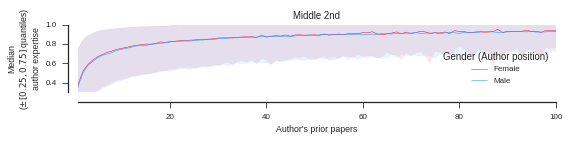

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,2))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_middle,],
        ["Middle 2nd",],
        [ax]
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].groupby(["auth_prev_papers", "gender"]).match_prop.agg([
        pd.Series.median, pd.Series.count,
        get_lower_quantile, get_upper_quantile
    ]).unstack()
    for j, gender in enumerate(genders):
        axi.fill_between(df_t.index,
                 df_t["get_lower_quantile"][gender],
                 df_t["get_upper_quantile"][gender],
                 color=gender_params[gender]["color"],
                 alpha=0.1)

        axi.plot(df_t.index, df_t["median"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                linewidth=linewidth,
                linestyle=linestyle)
    axi.set_ylim([0.3, 1.0])
    axi.set_xlim([1, 100])
    axi.set_title(title)
    axi.set_xlabel("Author's prior papers")
    axi.set_ylabel("Median\n($\pm [0.25, 0.75]$ quantiles)\nauthor expertise")
    axi.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_2_Figures/Author_papers_expertise_gender.middle_2nd.pdf", bbox_inches="tight")

mean                ci_l                ci_u          
gender                   F         M         F         M         F         M
auth_prev_papers                                                            
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1                 0.399195  0.383710  0.398753  0.383281  0.399637  0.384138
2                 0.515344  0.498875  0.514837  0.498398  0.515851  0.499352
3                 0.577696  0.565506  0.577150  0.564996  0.578242  0.566017
4                 0.619571  0.606632  0.618983  0.606104  0.620160  0.607160

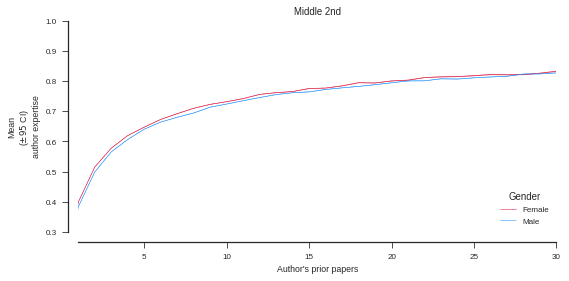

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_middle,],
        ["Middle 2nd",],
        [ax]
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].groupby(["auth_prev_papers", "gender"]).match_prop.apply(
        mean_confidence_interval
    ).unstack().unstack()
    display(df_t.head())
    for j, gender in enumerate(genders):
        axi.fill_between(df_t.index,
                 df_t["ci_l"][gender],
                 df_t["ci_u"][gender],
                 color=gender_params[gender]["color"],
                 alpha=0.5)

        axi.plot(df_t.index, df_t["mean"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                linewidth=linewidth,
                linestyle=linestyle)
    axi.set_ylim([0.3, 1.0])
    axi.set_xlim([1, 30])
    axi.set_title(title)
    axi.set_xlabel("Author's prior papers")
    axi.set_ylabel("Mean\n($\pm 95%$ CI)\nauthor expertise")
    axi.legend(title="Gender", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_2_Figures/Author_papers_expertise_gender.pdf", bbox_inches="tight")

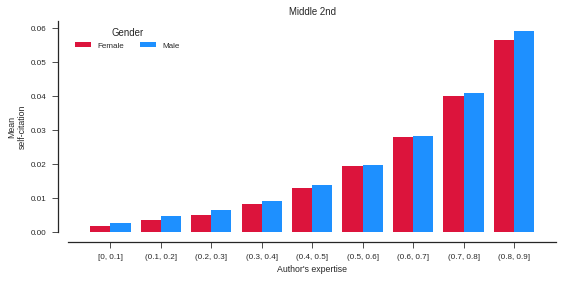

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for i, (df_t, title, axi) in enumerate(zip(
        [df_t_middle,],
        ["Middle 2nd",],
        [ax]
    )):
    
    df_t = df_t[~df_t.match_prop.isnull()].assign(
        expertise=lambda x: pd.cut(x["match_prop"],
                                   bins=np.arange(0,1,0.1),
                                   include_lowest=True,
                                   right=True
                                  )
    ).groupby(["expertise", "gender"]).is_self_cite.agg([
        pd.Series.mean, pd.Series.count,
    ]).unstack()
    width=0.4
    for j, gender in enumerate(genders):
        axi.bar(np.arange(df_t.index.shape[0]) + j*width, df_t["mean"][gender],
                label=gender_params[gender]["label"],
                color=gender_params[gender]["color"],
                width=width
               )
    #axi.set_ylim([0.3, 1.0])
    #axi.set_xlim([1, 100])
    axi.set_xticks(np.arange(df_t.index.shape[0]) + width / 2)
    axi.set_xticklabels(df_t.index.values)
    axi.set_title(title)
    axi.set_xlabel("Author's expertise")
    axi.set_ylabel("Mean\nself-citation")
    axi.legend(title="Gender", loc="upper left", ncol=2)
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_2_Figures/Self_citation_expertise_gender.pdf", bbox_inches="tight")

In [50]:
def model_predictions(df, formula, df_test, verbose=False, model_params=None):
    if model_params is None:
        model_params = dict()
    if verbose:
        print(df.shape, df_test.shape, formula)
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    if verbose:
        print "Created dataframes"
        print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X).fit(disp=verbose,
                           **model_params
                           #method='lbfgs', maxiter=50
                          )
    if verbose:
        display(model.summary2())
    _, X_test = patsy.dmatrices(formula, data=df_test, return_type="dataframe")
    if verbose:
        print X_test.shape
    y_test = model.predict(X_test)
    return y_test, model

In [51]:
df_test = pd.DataFrame({
            "auth_prev_papers": np.arange(0,150)
        }).assign(is_self_cite=1)
df_test.head()

,auth_prev_papers,is_self_cite
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [52]:
formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
               "+ I(auth_prev_papers == 1)"
               "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
              )
y_test, model = model_predictions(
    df_t_middle[(df_t_middle.gender == "M") 
               & (df_t_middle.auth_prev_papers <= 100)],
    formula,
    df_test, verbose=True)

((13275125, 64), (150, 2), 'is_self_cite ~ I(auth_prev_papers == 0)+ I(auth_prev_papers == 1)+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)')
Created dataframes
X.shape = (13275125, 5), y.shape = (13275125, 1)
Optimization terminated successfully.
         Current function value: 0.162760
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                     Logit                   Pseudo R-squared:        0.052       
Dependent Variable:        is_self_cite            AIC:                     4321334.6163
Date:                      2017-12-19 16:23        BIC:                     4321406.6234
No. Observations:          13275125                Log-Likelihood:          -2.1607e+06 
Df Model:                  4                       LL-Null:                 -2.2797e+06 
Df Residuals:              13275120                LLR p-value:             0.0000      
Converged:                 1.0000                  Scale:                   1.0000      
No. Iterations:            10.0000                                                      
----------------------------------------------------------------------------------------
                                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------
Intercept                              -4.6691   0.0135 -345.2146 0.0000 -4.6956 -4.6426
I(auth_prev_papers == 0)[T.True]       -1.4891   0.0219  -67.8593 0.0000 -1.5321 -1.4461
I(auth_prev_papers == 1)[T.True]       -0.2504   0.0124  -20.2693 0.0000 -0.2746 -0.2261
np.log10(auth_prev_papers + 1)          1.7647   0.0220   80.3346 0.0000  1.7216  1.8077
I(np.log10(auth_prev_papers + 1) ** 2) -0.3070   0.0084  -36.4530 0.0000 -0.3235 -0.2905
========================================================================================

"""

(150, 5)


In [53]:
model.summary2().tables[1].ix["I(auth_prev_papers == 0)[T.True]", ["Coef.", "Std.Err."]]

Coef.      -1.489103
Std.Err.    0.021944
Name: I(auth_prev_papers == 0)[T.True], dtype: float64

In [54]:
paper_filter = 100
df_t_data = df_t_middle
df_t_data = df_t_data[(df_t_data.auth_prev_papers <= paper_filter)]
df_t_full = df_t_data.groupby("gender")[["auth_prev_papers", "is_self_cite"]].agg([np.mean, np.std, len])
df_t_full

auth_prev_papers                      is_self_cite                    
                   mean        std       len         mean       std       len
gender                                                                       
-                   NaN        NaN         0          NaN       NaN         0
F             11.623575  16.859402   8104239     0.031909  0.175758   8104239
M             19.916481  23.337007  13275125     0.041197  0.198745  13275125

In [55]:
df_t_full["auth_prev_papers"]

,mean,std,len
gender,,,
-,NaN,NaN,0
F,11.623575,16.859402,8104239
M,19.916481,23.337007,13275125


In [56]:
df_t_full[("auth_prev_papers", "error")] = df_t_full[("auth_prev_papers", "std")] / np.sqrt(df_t_full[("auth_prev_papers", "len")])
df_t_full[("is_self_cite", "error")] = np.sqrt(
    (df_t_full[("is_self_cite", "mean")] * (1-df_t_full[("is_self_cite", "mean")]))/df_t_full[("is_self_cite", "len")])
df_t_full = df_t_full.sort_index(level=0, axis=1)
df_t_full

auth_prev_papers                                is_self_cite            \
                   mean        std       len     error         mean       std   
gender                                                                          
-                   NaN        NaN         0       NaN          NaN       NaN   
F             11.623575  16.859402   8104239  0.005922     0.031909  0.175758   
M             19.916481  23.337007  13275125  0.006405     0.041197  0.198745   

                            
             len     error  
gender                      
-              0       NaN  
F        8104239  0.000062  
M       13275125  0.000055

In [57]:
df_t_full.ix[gender, [("auth_prev_papers", "mean")]].values

array([ 19.91648131])

In [58]:
def get_age_self_cite_data(df_t_data):
    df_t = df_t_data.groupby(
        ["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
    df_t_full = df_t_data.assign(
        auth_prev_papers=np.log10(df_t_data["auth_prev_papers"] + 1).copy()
    ).groupby("gender")[["auth_prev_papers", "is_self_cite"]].agg([np.mean, np.std, len])
    df_t_full[("auth_prev_papers", "error")] = df_t_full[("auth_prev_papers", "std")] / np.sqrt(df_t_full[("auth_prev_papers", "len")])
    df_t_full[("is_self_cite", "error")] = np.sqrt(
        ((df_t_full[("is_self_cite", "mean")]
          * (1-df_t_full[("is_self_cite", "mean")])
         )/df_t_full[("is_self_cite", "len")]))
    df_t_full[("auth_prev_papers", "l_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] - df_t_full[("is_self_cite", "error")]) - 1
    df_t_full[("auth_prev_papers", "u_error")] = 10**(
        df_t_full[("is_self_cite", "mean")] + df_t_full[("is_self_cite", "error")]) - 1
    df_t_full = df_t_full.sort_index(level=0, axis=1)
    
    error = np.sqrt(df_t["mean"].multiply(1 - df_t["mean"]).divide(df_t["len"]))
    return df_t, df_t_full, error


def plot_age_vs_self_cite(axi, df_t_data, df_t, df_t_full, error, gender,
                          gender_params, plot_params, model_params,
                          formula, df_test, error_plot=True,
                          mean_line=False, verbose=False):
    """
    TODO: Add beta of Male Female indicator to the plot. 
    """
    error_params = gender_params[gender]
    if error_plot:
        axi.errorbar(df_t.index.values, df_t["mean"][gender].values,
                     yerr=error[gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **plot_params
                    )
    else:
        axi.plot(df_t.index.values, df_t["mean"][gender].values,
                     color=gender_params[gender]["color"],
                     #label=gender_params[gender]["label"],
                     marker=gender_params[gender]["marker"],
                     **dict([(k,v)
                         for k,v in plot_params.items()
                         if k not in set(["capsize", "elinewidth"])
                     ])
                    )

    x_mean = 10**(df_t_full.ix[gender, [("auth_prev_papers", "mean")]].values)-1
    y_mean = df_t_full.ix[gender, [("is_self_cite", "mean")]].values
    y_mean_err = df_t_full.ix[gender, [("is_self_cite", "error")]].values
    if mean_line:
        axi.axhline(
            y=y_mean[0],
            color=gender_params[gender]["color"],
            label="{} ({:.2f}% self-citations)".format(
                gender_params[gender]["label"], y_mean[0]*100),
            linestyle="--",
            lw=linewidth+1
        )
    else:
        axi.errorbar(
            x_mean, y_mean,
            #xerr=[df_t_full[("auth_prev_papers", "l_error")].values,
            #      df_t_full[("auth_prev_papers", "u_error")].values],
            yerr=y_mean_err,
            color=gender_params[gender]["color"],
            marker=gender_params[gender]["marker"],
            label="{}(x={:.2f},y={:.2f})".format(
                gender_params[gender]["label"], x_mean[0], y_mean[0]*100),
            ms=10,
        )

    print "Fitting model for %s" % gender
    model = None
    try:
        y_test, model = model_predictions(
                df_t_data,
                formula, df_test, verbose=verbose, model_params=model_params)
        axi.plot(df_test["auth_prev_papers"], y_test,
                 color=gender_params[gender]["color"],
                 linestyle="-",
                 linewidth=linewidth
                )
    except:
        print("Modeling failed.")
        print(df_t_data[df_t_data.auth_prev_papers < 2].auth_prev_papers.value_counts())
        import traceback
        traceback.print_exc()
    return axi, model

def plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=False):
    # Plot distribution
    y = (df_t["len"][gender] * 1./ df_t["len"][gender].sum())
    if cdf:
        y = y.cumsum()
    axi_dist.plot(df_t.index, y,
                  color=gender_params[gender]["color"],
                  label=gender_params[gender]["label"],
                  marker=gender_params[gender]["marker"],
                  linestyle="-",
                  alpha=0.5,
                  markersize=markersize
    )
    return axi_dist
    
    

In [59]:
plot_params

{'alpha': 0.6,
 'capsize': 0.5,
 'elinewidth': 0.01,
 'linestyle': 'none',
 'markersize': 3}

Fitting model for F
Fitting model for M


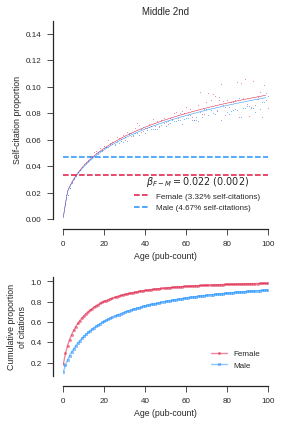

In [61]:
formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
               "+ I(auth_prev_papers == 1)"
               "+ C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
              )

fig, ax = plt.subplots(
    nrows=2, ncols=1,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios': [2, 1]},
    figsize=(4,6))
paper_filter = 100

for i, (df_t_data, title) in enumerate(zip(
        [df_t_middle, ],
        ["Middle 2nd",],
    )):
    axi, axi_dist = ax.flatten()
    #df_t_data = df_t_data[(df_t_data.auth_prev_papers <= paper_filter)]
        
    df_t, df_t_full, error = get_age_self_cite_data(df_t_data)
    for j, gender in enumerate(genders):
        df_test = pd.DataFrame({
                    "auth_prev_papers": np.arange(0,min([paper_filter, 150]))
                }).assign(is_self_cite=1, gender=gender)
        model_params = dict()
        axi, model = plot_age_vs_self_cite(axi,
                                    df_t_data, #[df_t_data.gender == gender],
                                    df_t, df_t_full, error, gender,
                                    gender_params, {
                                        k: (1 if k == "markersize" else v)
                                        for k,v in plot_params.items()
                                    }, model_params,
                                    formula, df_test, mean_line=True, verbose=False)
        axi_dist = plot_age_dist(axi_dist, df_t, gender, gender_params, cdf=True)
        legend_title = ""
        if model:
            model_stats = model.summary2().tables[1].ix[
                "C(gender, levels=['M', 'F'])[T.F]",
                ["Coef.", "Std.Err."]].values
            legend_title = "$\\beta_{F-M}=%.3f\ (%.3f)$" % (model_stats[0], model_stats[1])
    axi.set_ylim([0, 0.15])
    axi.set_xlim([0, 100])
    axi.set_title(title)
    axi.set_xlabel("Age (pub-count)")
    axi.set_ylabel("Self-citation proportion")
    axi.legend(loc='lower right', title=legend_title)

    axi_dist.legend(loc='lower right')
    axi_dist.set_xlabel("Age (pub-count)")
    axi_dist.set_ylabel("Cumulative proportion\nof citations")
    
#ax.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_2_Figures/Author_papers_self_cite_gender.pdf", bbox_inches="tight")

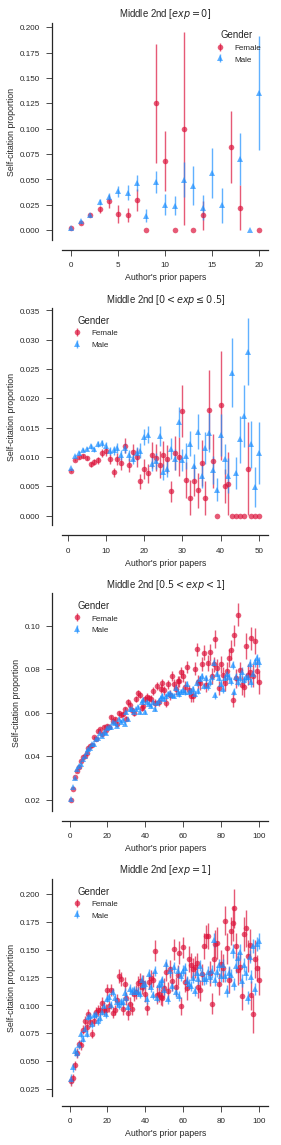

In [62]:
fig, ax = plt.subplots(4,1, sharey="row", figsize=(4,16))

filters = [
    (lambda x: x == 0, "$%s = 0$", 20),
    (lambda x: (x > 0) & (x <= 0.5), "$0 < %s \leq 0.5$", 50,),
    (lambda x: (x > 0.5) & (x < 1), "$0.5 < %s < 1$", 100),
    (lambda x: x == 1, "$%s = 1$", 100),
          ]
for i, (idx_filter, filter_title, paper_filter) in enumerate(filters):
    for j, (df_t, title, axi) in enumerate(zip(
            [df_t_middle,],
            ["Middle 2nd",],
            [ax[i]]
        )):
        df_t = df_t[idx_filter(df_t.match_prop) & (df_t.auth_prev_papers <= paper_filter)].groupby(
            ["auth_prev_papers", "gender"]).is_self_cite.agg([np.mean, len]).unstack()
        error = np.sqrt(df_t["mean"].multiply(1 - df_t["mean"]).divide(df_t["len"]))
        axi.errorbar(df_t.index, df_t["mean"]["F"], yerr=error["F"],
                 label="Female", color="crimson", linestyle="none", marker="o", alpha=0.7)
        axi.errorbar(df_t.index, df_t["mean"]["M"], yerr=error["M"],
                     label="Male", color="dodgerblue", linestyle="none", marker="^", alpha=0.7)
        axi.set_title("%s [%s]" % (title, filter_title % "exp"))
        axi.set_xlabel("Author's prior papers")
        axi.set_ylabel("Self-citation proportion")
        axi.legend(loc='best', title="Gender")
#ax.legend(title="Gender (Author position)", loc="lower right")
sns.despine(offset=10)
fig.tight_layout()
plt.savefig("Review_2_Figures/Author_papers_self_cite_gender_exp.pdf", bbox_inches="tight")

## Load Journal names

In [63]:
%%time
df_journals = pd.read_csv("data/FullArticlesData.txt", sep="\t", usecols=["PMID", "journal"])
df_journals.head()

CPU times: user 1min 23s, sys: 10.6 s, total: 1min 34s
Wall time: 4min 50s


In [64]:
df_journals.head()

,PMID,journal
0,26151966,J Hum Lact
1,26151965,J Hum Lact
2,26151955,EuroIntervention
3,26151954,EuroIntervention
4,26151953,EuroIntervention


In [65]:
df_journals.journal.value_counts().head(30)

J Biol Chem                   171068
Science                       167415
PLoS One                      133591
Lancet                        129945
Proc Natl Acad Sci U S A      121705
Nature                        104418
Br Med J                       97226
Biochim Biophys Acta           96039
Biochem Biophys Res Commun     78341
Phys Rev Lett                  76322
N Engl J Med                   72020
JAMA                           66849
BMJ                            65858
Biochemistry                   62430
J Immunol                      62245
Brain Res                      56834
Am J Physiol                   54726
Biochem J                      54355
J Bacteriol                    51716
J Am Chem Soc                  50057
Cancer Res                     48966
Ann N Y Acad Sci               47684
J Urol                         47368
Phys Rev B Condens Matter      46890
FEBS Lett                      46770
Appl Opt                       43386
Blood                          43160
J

## Journal categories

* MEDICINE - NEMJ, JAMA, LANCET
* BIOLOGY - CELL, Journal of Bio Chem
* Bioinformatics - PLoS Com Bio, BMC BioInfo
* EPIDEMIOLOGY - MMWR. Morbidity and Mortality Weekly Report, Emerging Infectious Diseases, International Journal of Epidemiology
* DENTISTRY - Journal of Endodontics, Journal of Clinical Periodontology, Journal of Dental Research
* GENERIC - Proc Natl Acad Sci U S A, Nature, Science, PLoS One

In [66]:
JOURNAL_NAMES  = dict(
    GENERIC=set(['Proc Natl Acad Sci U S A', 'Nature', 'Science',
                 'Ann N Y Acad Sci',]), # General Science
    MEDICINE = set(['JAMA', 'Lancet', 'N Engl J Med',
                    'BMJ', 'Cancer Res', 'Clin Cancer Res', 'J Clin Oncol',
                    'J Am Coll Cardiol', 'Gut', 'Circulation', 'Blood',
                    'J Immunol', 'Brain Res', #'Am J Physiol',
                    'J Urol', 
                    #'Med J Aust', 'Ugeskr Laeger'
                   ]), # General Medicine
    BIOLOGY = set(['J Biol Chem', 'Cell',  'Adv Exp Med Biol',
                   'Mol Cell', 'Biochim Biophys Acta', 'Biochemistry',
                   'Biochem J', 'FEBS Lett', 'J Bacteriol', 'J Virol',
                   'Bioinformatics', 'Nucleic Acids Res',
                  ]), # Biology
)

JOURNAL_NAMES

{'BIOLOGY': {'Adv Exp Med Biol',
  'Biochem J',
  'Biochemistry',
  'Biochim Biophys Acta',
  'Bioinformatics',
  'Cell',
  'FEBS Lett',
  'J Bacteriol',
  'J Biol Chem',
  'J Virol',
  'Mol Cell',
  'Nucleic Acids Res'},
 'GENERIC': {'Ann N Y Acad Sci',
  'Nature',
  'Proc Natl Acad Sci U S A',
  'Science'},
 'MEDICINE': {'BMJ',
  'Blood',
  'Brain Res',
  'Cancer Res',
  'Circulation',
  'Clin Cancer Res',
  'Gut',
  'J Am Coll Cardiol',
  'J Clin Oncol',
  'J Immunol',
  'J Urol',
  'JAMA',
  'Lancet',
  'N Engl J Med'}}

In [67]:
df_journals[df_journals.journal.isin(JOURNAL_NAMES["MEDICINE"])].journal.value_counts()

Lancet               129945
N Engl J Med          72020
JAMA                  66849
BMJ                   65858
J Immunol             62245
Brain Res             56834
Cancer Res            48966
J Urol                47368
Blood                 43160
Circulation           40094
J Am Coll Cardiol     21580
J Clin Oncol          21075
Gut                   15952
Clin Cancer Res       14845
Name: journal, dtype: int64

In [68]:
pd.concat([df_journals[df_journals.journal.isin(v)
                      ][["PMID", "journal"]].assign(JOURNAL_TYPE=k).reset_index(drop=True)
          for k,v in JOURNAL_NAMES.items()]).head()

,PMID,journal,JOURNAL_TYPE
0,26151898,Brain Res,MEDICINE
1,26151676,J Urol,MEDICINE
2,26151285,JAMA,MEDICINE
3,26151284,JAMA,MEDICINE
4,26151282,JAMA,MEDICINE


In [69]:
df_test.assign(gender=gender).head()

,auth_prev_papers,gender,is_self_cite
0,0,M,1
1,1,M,1
2,2,M,1
3,3,M,1
4,4,M,1


In [70]:
def get_journal_data(df_t_data, journal_name):
    journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
    print(journal_name, len(journal_ids))
    df_t_data = df_t_data[(df_t_data.source_id.isin(journal_ids))]
    return df_t_data
    

def plot_journal_data(formula, selected_journals, filename,
                      paper_filter = 10000, min_citations=20000, verbose=False):
    nrows=len(selected_journals)
    fig = plt.figure(figsize=(4,4*nrows))
    grid_size=(nrows,1)
    journal_group_stats = []
    for k, journal_name in enumerate(selected_journals):
        journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
        print(journal_name, len(journal_ids))
        for i, (df_t_data, title) in enumerate(zip(
                [df_t_middle,],
                ["Middle 2nd", "Last"],
            )):
            axi = plt.subplot2grid(grid_size, (k, i))
            df_t_data = df_t_data[
                (df_t_data.auth_prev_papers <= paper_filter)
                & (df_t_data.source_id.isin(journal_ids))
            ]
            df_t, df_t_full, error = get_age_self_cite_data(df_t_data)
            print(title, df_t_data.shape)
            if df_t_data.shape[0] < min_citations:
                    continue
            legend_title=""
            model_stats = [np.nan, np.nan, np.nan]
            for j, gender in enumerate(genders):
                df_test = pd.DataFrame({
                    "auth_prev_papers": np.arange(0,min([paper_filter, 150]))
                }).assign(is_self_cite=1, gender=gender)
                model_params = dict(method='lbfgs', maxiter=50)
                axi, model = plot_age_vs_self_cite(axi, df_t_data, df_t, df_t_full,
                                            error, gender, gender_params, plot_params, model_params,
                                            formula, df_test, mean_line=True, error_plot=False)
                if model:
                    model_stats = model.summary2().tables[1].ix[
                        "C(gender, levels=['M', 'F'])[T.F]",
                        ["Coef.", "Std.Err.", "P>|z|"]].values.tolist()
                    legend_title = "$\\beta_{F-M}=%.3f\\ (%.3f)$" % (model_stats[0], model_stats[1])
            journal_group_stats.append(
                [journal_name, title, df_t_data.shape[0]]+model_stats)
            axi.set_ylim([0, 0.24])
            xlim_max = 150
            if title == "First":
                xlim_max = 50
            axi.set_xlim([0, min([paper_filter, xlim_max])])
            axi.set_title("{0} [n={1:,}]\n({2})".format(title, df_t_data.shape[0], journal_name))
            axi.set_xlabel("Age (pub count)")
            axi.set_ylabel("Self-citation proportion")
            legend = axi.legend(loc='upper left', title=legend_title, ncol=1)
            legend.get_frame().set_facecolor('#FFFFFF')
        #ax.legend(title="Gender (Author position)", loc="lower right")
    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    return fig, journal_group_stats

In [71]:
def get_proportion(journal_name, paper_filter=100, verbose=False):
    journal_ids = set(df_journals.ix[df_journals.journal == journal_name, "PMID"].values)
    if verbose:
        print(journal_name, len(journal_ids))
    print("Paper cutoff: {}".format(paper_filter))
    for i, (df_t_data, title) in enumerate(zip(
            [df_t_middle,],
            ["Middle 2nd",],
        )):
        df_t = df_t_data[
            (df_t_data.source_id.isin(journal_ids))
        ]
        print(df_t.shape)
        display(df_t.gender.value_counts())
        total_papers = df_t.shape[0]
        df_t = df_t[(df_t.auth_prev_papers <= paper_filter)]
        print("{}\tProportion: {:.2f}%".format(title, df_t.shape[0]* 100./total_papers))       

In [72]:
get_proportion('Proc Natl Acad Sci U S A', paper_filter=30)

Paper cutoff: 30
(273491, 64)


M    177676
F     95815
-         0
Name: gender, dtype: int64

Middle 2nd	Proportion: 85.18%


('Cell', 17515)
('Middle 2nd', (29158, 64))
Fitting model for F
Fitting model for M


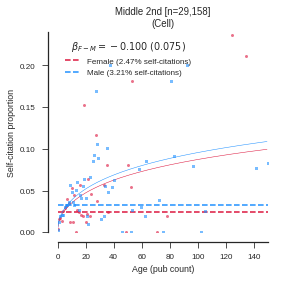

In [73]:
journal_formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
                "+ I(auth_prev_papers == 1)"
                "+ C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1)"
                "+ I(np.log10(auth_prev_papers + 1)**2)"
              )
selected_journals = {'Cell',}
filename = "Review_2_Figures/Author_papers_self_cite_gender_journals.pdf"
fig, journal_group_stats = plot_journal_data(journal_formula, selected_journals, filename)

In [74]:
pd.DataFrame(journal_group_stats, columns=[
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]).pivot(index="Journal", columns="Author Position").reorder_levels([1,0], axis=1).sortlevel(0, axis=1)

Author Position Middle 2nd                            
                 citations      beta    stderr p-value
Journal                                               
Cell                 29158 -0.100102  0.075176   0.183

# Plot per journal category

MEDICINE
('Cancer Res', 48966)
('Middle 2nd', (131032, 64))
Fitting model for F
Fitting model for M
('Circulation', 40094)
('Middle 2nd', (86390, 64))
Fitting model for F
Fitting model for M
('N Engl J Med', 72020)
('Middle 2nd', (25653, 64))
Fitting model for F
Fitting model for M
('BMJ', 65858)
('Middle 2nd', (18120, 64))
('J Am Coll Cardiol', 21580)
('Middle 2nd', (47203, 64))
Fitting model for F
Fitting model for M
('J Clin Oncol', 21075)
('Middle 2nd', (57160, 64))
Fitting model for F
Fitting model for M
('J Immunol', 62245)
('Middle 2nd', (201043, 64))
Fitting model for F
Fitting model for M
('JAMA', 66849)
('Middle 2nd', (28204, 64))
Fitting model for F
Fitting model for M
('Gut', 15952)
('Middle 2nd', (28085, 64))
Fitting model for F
Fitting model for M
('Clin Cancer Res', 14845)
('Middle 2nd', (89800, 64))
Fitting model for F
Fitting model for M
('Brain Res', 56834)
('Middle 2nd', (88530, 64))
Fitting model for F
Fitting model for M
('J Urol', 47368)
('Middle 2nd', (44662, 64)

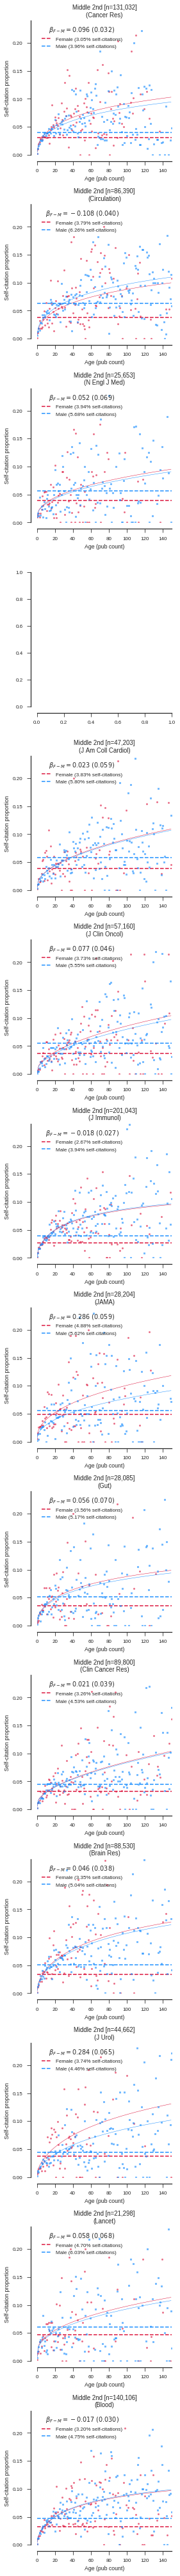

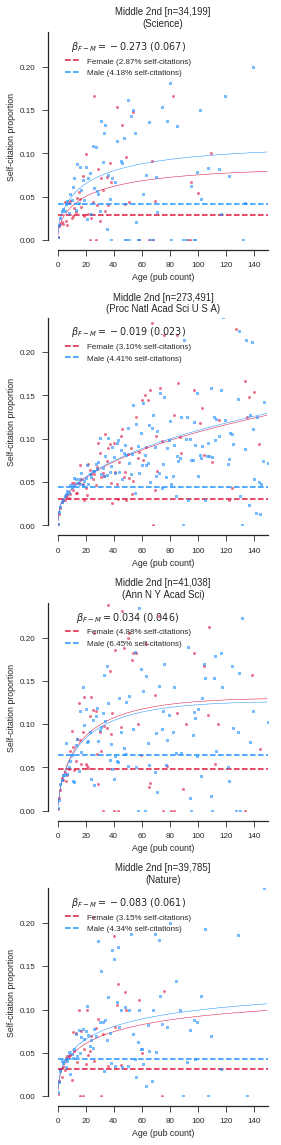

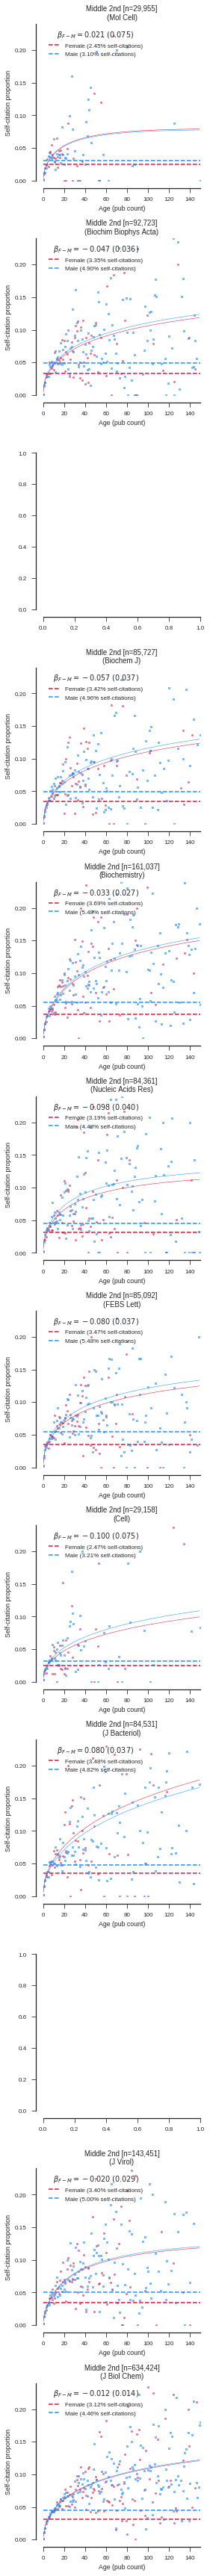

In [75]:
journal_formula = ("is_self_cite ~ "
               "I(auth_prev_papers == 0)"
                "+ I(auth_prev_papers == 1)"
                " + C(gender, levels=['M', 'F'])"
               "+ np.log10(auth_prev_papers + 1)"
                "+ I(np.log10(auth_prev_papers + 1)**2)"
              )
df_journal_stats = {}
for journal_cat, selected_journals in JOURNAL_NAMES.items():
    print(journal_cat)
    filename = "Review_2_Figures/Author_papers_self_cite_gender_journals_{}.pdf".format(journal_cat)
    fig, journal_group_stats = plot_journal_data(journal_formula, selected_journals, filename)
    df_journal_stats[journal_cat] = journal_group_stats

In [77]:
journal_table_cols = [
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]
JOURNAL_CAT_NAMINGS={
    "GENERIC": "Science",
    "MEDICINE": "Medicine",
    "BIOLOGY": "Biology",
}
df_journal_stats_all = pd.concat(
    {
        JOURNAL_CAT_NAMINGS[k]: pd.DataFrame(journal_group_stats,
                        columns=journal_table_cols).pivot(
            index="Journal", columns="Author Position"
        ).reorder_levels([1,0], axis=1).sortlevel(0, axis=1).sort_values(
            ("Middle 2nd", "citations"), ascending=False)
        
        for k,journal_group_stats in df_journal_stats.items()
    }
)
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    display(df_journal_stats_all)

Author Position                   Middle 2nd                      
                                   citations   beta stderr p-value
         Journal                                                  
Biology  J Biol Chem                  634424 -0.012  0.014   0.387
         Biochemistry                 161037 -0.033  0.027   0.217
         J Virol                      143451 -0.020  0.029   0.479
         Biochim Biophys Acta          92723 -0.047  0.036   0.198
         Biochem J                     85727 -0.057  0.037   0.125
         FEBS Lett                     85092 -0.080  0.037   0.032
         J Bacteriol                   84531  0.080  0.037   0.032
         Nucleic Acids Res             84361 -0.098  0.040   0.013
         Mol Cell                      29955  0.021  0.075   0.779
         Cell                          29158 -0.100  0.075   0.183
Medicine J Immunol                    201043 -0.018  0.027   0.506
         Blood                        140106 -0.017  0.030   0.576
         Cancer Res                   131032  0.096  0.032   0.003
         Clin Cancer Res               89800  0.021  0.039   0.583
         Brain Res                     88530  0.046  0.038   0.231
         Circulation                   86390 -0.108  0.040   0.007
         J Clin Oncol                  57160  0.077  0.046   0.095
         J Am Coll Cardiol             47203  0.023  0.059   0.703
         J Urol                        44662  0.284  0.065   0.000
         JAMA                          28204  0.286  0.059   0.000
         Gut                           28085  0.056  0.070   0.424
         N Engl J Med                  25653  0.052  0.069   0.453
         Lancet                        21298  0.058  0.068   0.392
Science  Proc Natl Acad Sci U S A     273491 -0.019  0.023   0.398
         Ann N Y Acad Sci              41038  0.034  0.046   0.465
         Nature                        39785 -0.083  0.061   0.169
         Science                       34199 -0.273  0.067   0.000

In [78]:
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    print(df_journal_stats_all.to_latex())

\begin{tabular}{llrrrr}
\toprule
        &                  & Middle 2nd &        &        &         \\
        &                  &  citations &   beta & stderr & p-value \\
{} & Journal &            &        &        &         \\
\midrule
Biology & J Biol Chem &     634424 & -0.012 &  0.014 &   0.387 \\
        & Biochemistry &     161037 & -0.033 &  0.027 &   0.217 \\
        & J Virol &     143451 & -0.020 &  0.029 &   0.479 \\
        & Biochim Biophys Acta &      92723 & -0.047 &  0.036 &   0.198 \\
        & Biochem J &      85727 & -0.057 &  0.037 &   0.125 \\
        & FEBS Lett &      85092 & -0.080 &  0.037 &   0.032 \\
        & J Bacteriol &      84531 &  0.080 &  0.037 &   0.032 \\
        & Nucleic Acids Res &      84361 & -0.098 &  0.040 &   0.013 \\
        & Mol Cell &      29955 &  0.021 &  0.075 &   0.779 \\
        & Cell &      29158 & -0.100 &  0.075 &   0.183 \\
Medicine & J Immunol &     201043 & -0.018 &  0.027 &   0.506 \\
        & Blood &     140106 & -0.01

In [79]:
df_journal_stats_all.shape

(27, 4)

# Plot full models for journals

In [80]:
df_t_middle.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

In [81]:
journal_model_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=['M', 'F'])"
           #"+ C(source_country, levels=TOP_15_COUNTRIES)"
           #"+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) "#"+ I(np.log10(source_ncites)**3)"
           #"+ I(source_n_authors > 20)"
           #              " + np.log10(np.clip(source_n_authors, 0, 20))"
           #"+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           #"+ np.log10(source_n_mesh_ex + 1) + "#"I(source_n_mesh_ex == 0)" 
           #"+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0)"
                         " + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) "
                         "+ np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           #"+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           #"+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           #"+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           #"+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

In [82]:
journal_full_model_stats = dict()
for journal_cat, selected_journals in JOURNAL_NAMES.items():
    journal_group_full_model_stats = []
    for journal_name in selected_journals:
        for i, (df_t_data, title) in enumerate(zip(
                        [df_t_middle,],
                        ["Middle 2nd",],
                    )):
            print(title)
            model_stats = [np.nan, np.nan, np.nan]
            df_t_data = get_journal_data(df_t_data, journal_name).copy()
            #prepare_data(df_t_data)
            try:
                y_test, model = model_predictions(
                    df_t_data, journal_model_formula,
                    df_t_data.iloc[:3], verbose=False,
                    model_params=dict(method='lbfgs', maxiter=100))
                model_stats = model.summary2().tables[1].ix[
                        "C(gender, levels=['M', 'F'])[T.F]",
                        ["Coef.", "Std.Err.", "P>|z|"]].values.tolist()
            except:
                print("Failed to fit")
            journal_group_full_model_stats.append(
                [journal_name, title, df_t_data.shape[0]]+model_stats
            )
    journal_full_model_stats[journal_cat] = journal_group_full_model_stats

Middle 2nd
('Cancer Res', 48966)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Circulation', 40094)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('N Engl J Med', 72020)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('BMJ', 65858)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Am Coll Cardiol', 21580)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Clin Oncol', 21075)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Immunol', 62245)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('JAMA', 66849)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Gut', 15952)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Clin Cancer Res', 14845)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Brain Res', 56834)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Urol', 47368)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Lancet', 129945)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Blood', 43160)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Science', 167415)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Proc Natl Acad Sci U S A', 121705)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Ann N Y Acad Sci', 47684)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Nature', 104418)
Middle 2nd
('Mol Cell', 5804)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Biochim Biophys Acta', 96039)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Adv Exp Med Biol', 31938)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Biochem J', 54355)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Biochemistry', 62430)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Nucleic Acids Res', 39570)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('FEBS Lett', 46770)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Cell', 17515)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Bacteriol', 51716)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('Bioinformatics', 10026)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Virol', 42269)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Middle 2nd
('J Biol Chem', 171068)


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [83]:
journal_table_cols = [
    "Journal", "Author Position", "citations",
    "beta", "stderr", "p-value"
]
JOURNAL_CAT_NAMINGS={
    "GENERIC": "Science",
    "MEDICINE": "Medicine",
    "BIOLOGY": "Biology",
}

df_journal_full_model_stats = pd.concat(
    {
        JOURNAL_CAT_NAMINGS[k]: pd.DataFrame(journal_group_stats,
                        columns=journal_table_cols).pivot(
            index="Journal", columns="Author Position"
        ).reorder_levels([1,0], axis=1).sortlevel(0, axis=1).sort_values(
            ("Middle 2nd", "citations"), ascending=False)
        
        for k,journal_group_stats in journal_full_model_stats.items()
    }
)
with pd.option_context("display.precision",3, 'display.float_format', lambda x: '%.3f' % x):
    display(df_journal_full_model_stats)

Author Position                   Middle 2nd                      
                                   citations   beta stderr p-value
         Journal                                                  
Biology  J Biol Chem                  634424 -0.022  0.015   0.127
         Biochemistry                 161037  0.003  0.028   0.923
         J Virol                      143451 -0.018  0.030   0.547
         Biochim Biophys Acta          92723 -0.051  0.038   0.175
         Biochem J                     85727 -0.035  0.038   0.363
         FEBS Lett                     85092 -0.064  0.038   0.096
         J Bacteriol                   84531  0.070  0.039   0.072
         Nucleic Acids Res             84361 -0.066  0.041   0.104
         Mol Cell                      29955 -0.025  0.076   0.737
         Cell                          29158 -0.043  0.077   0.578
         Bioinformatics                15477  0.239  0.110   0.029
         Adv Exp Med Biol              15208  0.184  0.078   0.018
Medicine J Immunol                    201043 -0.036  0.028   0.190
         Blood                        140106 -0.024  0.030   0.428
         Cancer Res                   131032  0.093  0.033   0.005
         Clin Cancer Res               89800  0.030  0.040   0.451
         Brain Res                     88530  0.049  0.040   0.223
         Circulation                   86390 -0.029  0.041   0.484
         J Clin Oncol                  57160  0.091  0.047   0.052
         J Am Coll Cardiol             47203  0.078  0.061   0.201
         J Urol                        44662  0.356  0.068   0.000
         JAMA                          28204  0.312  0.061   0.000
         Gut                           28085  0.071  0.072   0.324
         N Engl J Med                  25653  0.093  0.072   0.196
         Lancet                        21298  0.155  0.070   0.027
         BMJ                           18120  0.237  0.084   0.005
Science  Proc Natl Acad Sci U S A     273491  0.035  0.023   0.135
         Ann N Y Acad Sci              41038  0.028  0.048   0.554
         Nature                        39785 -0.008  0.062   0.894
         Science                       34199 -0.215  0.067   0.001

Medicine
Science
Biology


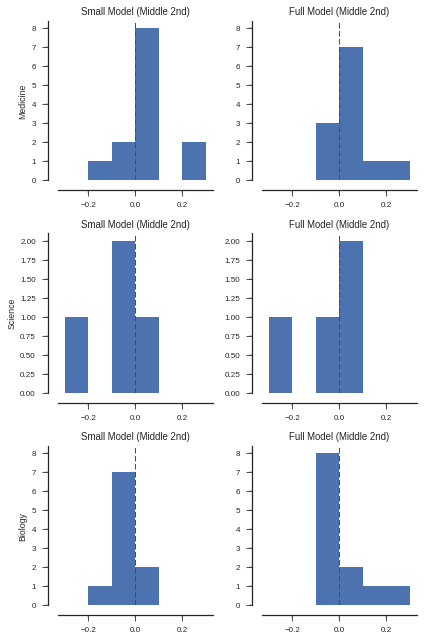

In [84]:
fig, ax = plt.subplots(3,2, sharex=True, sharey="row", figsize=(6,9))
bins=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
for j, journal_cat in enumerate(set(df_journal_stats_all.index.get_level_values(0).tolist())):
    print journal_cat
    for i, title in enumerate(["Middle 2nd",]):
        df_journal_stats_all.reset_index(level=1).ix[
            journal_cat, (title, "beta")].plot(kind="hist", bins=bins, ax=ax[j, 2*i])
        df_journal_full_model_stats.reset_index(level=1).ix[
            journal_cat, (title, "beta")].plot(kind="hist", bins=bins, ax=ax[j, 2*i+1])
        ax[j, 2*i].set_title("Small Model ({})".format(title))
        ax[j, 2*i].axvline(x=0, color="r", linestyle="--", lw=1)
        ax[j, 2*i+1].set_title("Full Model ({})".format(title))
        ax[j, 2*i+1].axvline(x=0, color="r", linestyle="--", lw=1)
    ax[j, 0].set_ylabel(journal_cat)
sns.despine(offset=10)
fig.tight_layout()

In [85]:
sns.color_palette(["#ff0000", "#000000"])

[(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]

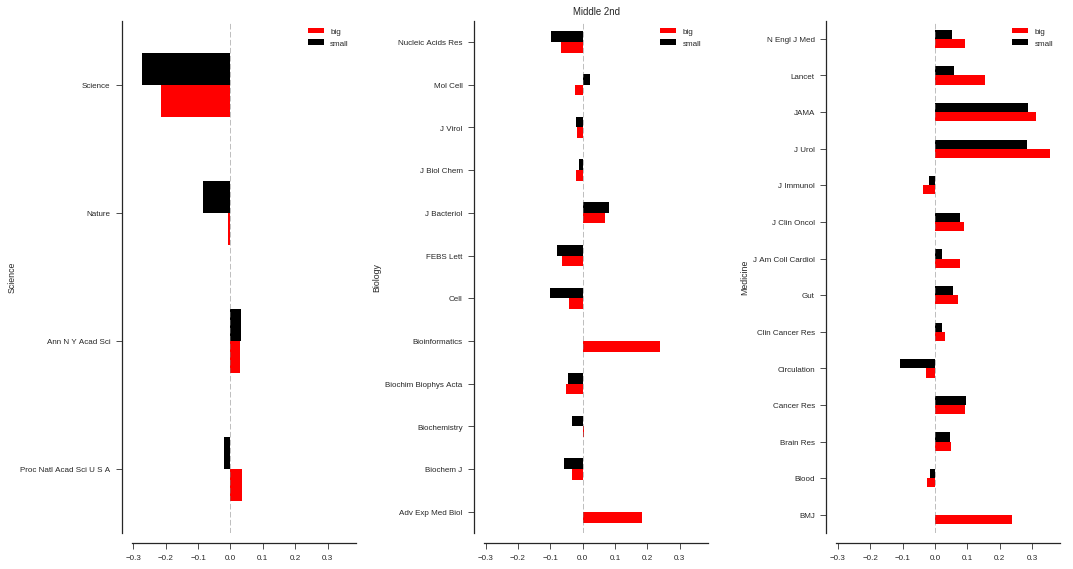

In [86]:
with sns.color_palette(["#ff0000", "#000000"]):
    fig, ax = plt.subplots(1,3, sharex=True, figsize=(15, 8), squeeze=False)
    for i, title in enumerate(["Middle 2nd",]):
        for j, journal_name in enumerate(["Science", "Biology", "Medicine"]):
            pd.concat({
                "small": df_journal_stats_all.ix[journal_name,(title, "beta")],
                "big": df_journal_full_model_stats.ix[journal_name,(title, "beta")]
            }, axis=1).plot.barh(ax=ax[i,j])
            ax[i,j].set_ylabel(journal_name)
            ax[i,j].axvline(x=0, linestyle="--", color="0.5", linewidth=0.5)
        ax[i, 1].set_title(title)

    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig("Review_2_Figures/Journal_cat_betas_big_small.pdf", bbox_inches="tight")

## Indiv journal analysis

In [88]:
journal_model_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=['M', 'F'])"
           "+ C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) "#"+ I(np.log10(source_ncites)**3)"
           #"+ I(source_n_authors > 20)"
           #              " + np.log10(np.clip(source_n_authors, 0, 20))"
           #"+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + "#"I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0)"
                         " + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) "
                         "+ np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
            "+ I(match_prop == 0) + I(match_prop == 1) + match_prop + I(match_prop**2)"
          )

In [89]:
for journal_name in ["J Biol Chem"]:
    for i, (df_t_data, title) in enumerate(zip(
                    [df_t_middle,],
                    ["First",],
                )):
        print(title)
        model_stats = [np.nan, np.nan, np.nan]
        df_t_data = get_journal_data(df_t_data, journal_name).copy()
        #prepare_data(df_t_data)
        try:
            y_test, model = model_predictions(
                df_t_data, journal_model_formula,
                df_t_data.iloc[:3], verbose=False,
                model_params=dict(method='lbfgs', maxiter=100))
            display(model.summary2())
        except:
            print("Failed to fit")

First
('J Biol Chem', 171068)
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
=====================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.206      
Dependent Variable:                  is_self_cite                      AIC:                               166588.4867
Date:                                2017-12-19 17:23                  BIC:                               167338.2779
No. Observations:                    634424                            Log-Likelihood:                    -83228.    
Df Model:                            65                                LL-Null:                           -1.0486e+05
Df Residuals:                        634358                            LLR p-value:                       0.0000     
Converged:                           0.0000                            Scale:                             1.0000     
---------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.1643      nan      nan    nan     nan     nan
I(auth_prev_papers == 0)[T.True]                                     -0.4864   0.5598  -0.8689 0.3849 -1.5835  0.6108
I(auth_prev_papers == 1)[T.True]                                     -0.1045   0.0493  -2.1170 0.0343 -0.2012 -0.0077
C(gender, levels=['M', 'F'])[T.F]                                     0.0204   0.0152   1.3384 0.1808 -0.0095  0.0503
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                 0.0359   0.2136   0.1680 0.8666 -0.3828  0.4546
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0026   0.0304  -0.0863 0.9312 -0.0622  0.0569
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.1954   0.0390   5.0084 0.0000  0.1189  0.2718
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0034   0.0347   0.0976 0.9222 -0.0646  0.0714
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                  0.0129   0.0379   0.3411 0.7330 -0.0613  0.0872
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.2405   0.0541   4.4461 0.0000  0.1345  0.3465
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  0.0444   0.0340   1.3046 0.1920 -0.0223  0.1111
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.1733   0.1445  -1.1992 0.2305 -0.4566  0.1099
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.0577   0.0533  -1.0816 0.2794 -0.1622  0.0468
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   0.2257   0.0528   4.2737 0.0000  0.1222  0.3291
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.0634   0.0646   0.9812 0.3265 -0.0632  0.1901
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                 -0.0133   0.0563  -0.2371 0.8126 -0.1237  0.0970
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.2988   0.1640  -1.8226 0.0684 -0.6202  0.0225
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   0.0634   0.0260   2.4394 0.0147  0.0125  0.1143
I(sink_n_mesh_ex == 0)[T.True]                                       -0.5650   0.2550  -2.2155 0.0267 -1.0649 -0.0652
I(year_span < 0)[T.True]                                              0.0354   1.3120   0.0270 0.9785 -2.5360  2.6069
I(year_span == 0)[T.True]                                             0.5911   0.0532  11.1079 0.0000  0.4868  0.6954
I(sink_prev_ncites == 0)[T.True]                                      0.1580   0.0382   4.1359 0.0000  0.0831

In [90]:
df_journal_full_model_stats[
    (df_journal_full_model_stats[("Middle 2nd", "p-value")] < 0.05)
    #& (df_journal_full_model_stats[("Last", "beta")] > 0)
]

Author Position           Middle 2nd                                  
                           citations      beta    stderr       p-value
         Journal                                                      
Biology  Bioinformatics        15477  0.239425  0.109796  2.921111e-02
         Adv Exp Med Biol      15208  0.184078  0.077788  1.796172e-02
Medicine Cancer Res           131032  0.093137  0.033078  4.867962e-03
         J Urol                44662  0.356277  0.067581  1.350741e-07
         JAMA                  28204  0.312358  0.060921  2.939382e-07
         Lancet                21298  0.155162  0.070327  2.736209e-02
         BMJ                   18120  0.236554  0.083707  4.713789e-03
Science  Science               34199 -0.214679  0.067473  1.464161e-03

In [91]:
print("Journal with middle 2nd authorships having significant gender effect.")
df_journal_full_model_stats[
    (df_journal_full_model_stats[("Middle 2nd", "p-value")] < 0.05)
    #& (df_journal_full_model_stats[("Last", "beta")] > 0)
]

Journal with middle 2nd authorships having significant gender effect.


Author Position           Middle 2nd                                  
                           citations      beta    stderr       p-value
         Journal                                                      
Biology  Bioinformatics        15477  0.239425  0.109796  2.921111e-02
         Adv Exp Med Biol      15208  0.184078  0.077788  1.796172e-02
Medicine Cancer Res           131032  0.093137  0.033078  4.867962e-03
         J Urol                44662  0.356277  0.067581  1.350741e-07
         JAMA                  28204  0.312358  0.060921  2.939382e-07
         Lancet                21298  0.155162  0.070327  2.736209e-02
         BMJ                   18120  0.236554  0.083707  4.713789e-03
Science  Science               34199 -0.214679  0.067473  1.464161e-03